# Proyecto: Modelo que detecta críticas negativas de forma automática a partir de reseñas de películas de IMDB.

**Por María Payró González**

In [14]:
#Cargar librerías
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm import tqdm
from tqdm.auto import tqdm

import re
import string

import sklearn.metrics as metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


import nltk
from nltk.corpus import stopwords

from lightgbm import LGBMClassifier

import spacy

import torch
import transformers

In [28]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [29]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [31]:
# Cargar datos
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

df_reviews.info()
df_reviews.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


0    23715
1    23616
Name: pos, dtype: int64
train    23796
test     23535
Name: ds_part, dtype: int64


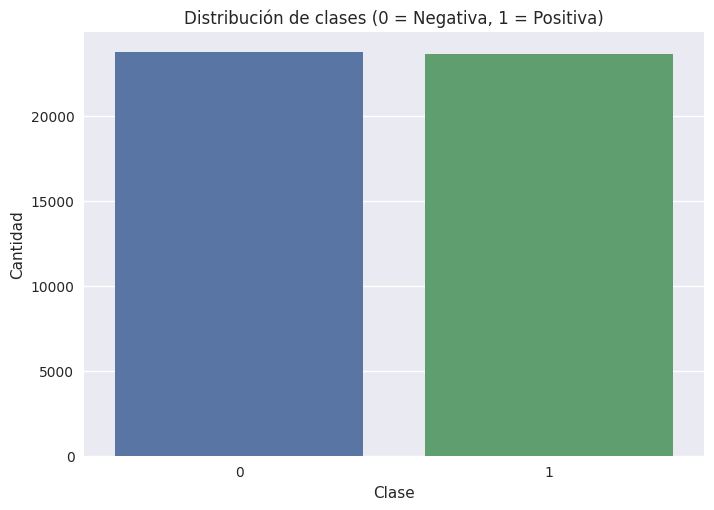

In [32]:
# Análisis de la variable objetivo ('pos') y la partición ('ds_part')

# Conteo de reseñas por clase (positiva = 1, negativa = 0)
print(df_reviews['pos'].value_counts())

# Distribución por tipo de partición (entrenamiento / prueba)
print(df_reviews['ds_part'].value_counts())

# Gráfico de distribución de clases
sns.countplot(data=df_reviews, x='pos')
plt.title('Distribución de clases (0 = Negativa, 1 = Positiva)')
plt.xlabel('Clase')
plt.ylabel('Cantidad')
plt.show()


In [33]:
# Limpieza básica del texto

def clean_text(text):
    # Minúsculas, eliminar signos de puntuación y números
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", "", text)
    text = re.sub(r"\d+", "", text)
    return text.strip()

# Crear nueva columna con el texto limpio
df_reviews['review_clean'] = df_reviews['review'].progress_apply(clean_text)

# Ver un ejemplo
df_reviews[['review', 'review_clean']].sample(3)


  0%|          | 0/47331 [00:00<?, ?it/s]

,review,review_clean
39983,When I began watching The Muppets Take Manhatt...,when i began watching the muppets take manhatt...
42249,"Words can hardly describe it, so I'll be brief...",words can hardly describe it so ill be brief t...
44297,"this movie is, despite its ""independent"" statu...",this movie is despite its independent status a...


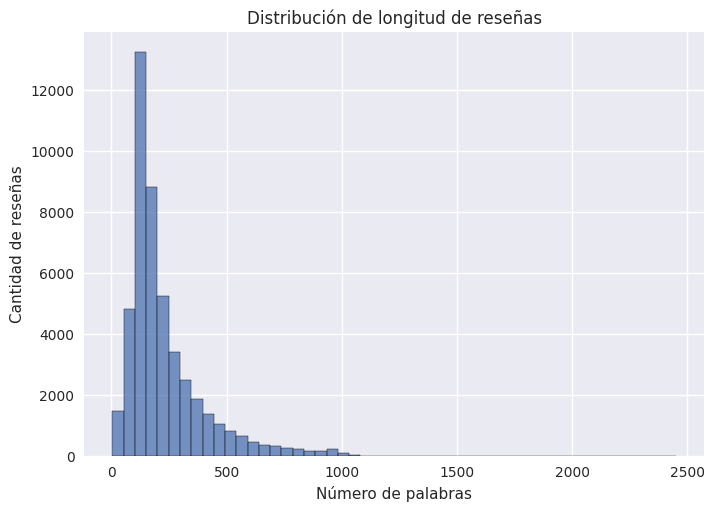

Longitud mínima: 4
Longitud máxima: 2450


In [34]:
# Longitud de reseñas
df_reviews['review_length'] = df_reviews['review_clean'].str.split().apply(len)

sns.histplot(df_reviews['review_length'], bins=50)
plt.title('Distribución de longitud de reseñas')
plt.xlabel('Número de palabras')
plt.ylabel('Cantidad de reseñas')
plt.show()

# Longitudes mínimas y máximas
print("Longitud mínima:", df_reviews['review_length'].min())
print("Longitud máxima:", df_reviews['review_length'].max())


## Conclusión sobre el análisis exploratorio

A partir del análisis inicial del conjunto de datos, vimos que tiene 47,331 reseñas en total y 17 columnas. Aunque hay varias columnas relacionadas con detalles de las películas (como el título, género, duración, etc.), para nuestro proyecto nos enfocamos principalmente en la columna review, que contiene el texto de cada reseña, y en pos, que indica si la reseña es positiva (1) o negativa (0). Los datos ya están divididos en entrenamiento y prueba en la columna ds_part, lo cual nos facilita el proceso de modelado. Al revisar la distribución de clases, encontramos que hay prácticamente la misma cantidad de reseñas positivas y negativas (23,715 negativas y 23,616 positivas), lo que indica que las clases están muy bien balanceadas, así que no necesitamos hacer ajustes como sobremuestreo. También notamos que las longitudes de las reseñas son muy variadas: algunas son muy cortas (de solo 4 palabras), y otras muy largas (hasta 2,450 palabras), lo cual es importante tener en cuenta al momento de vectorizar el texto o usar ciertos modelos más sensibles a la longitud.


## EDA

Veamos el número de películas y reseñas a lo largo de los años.

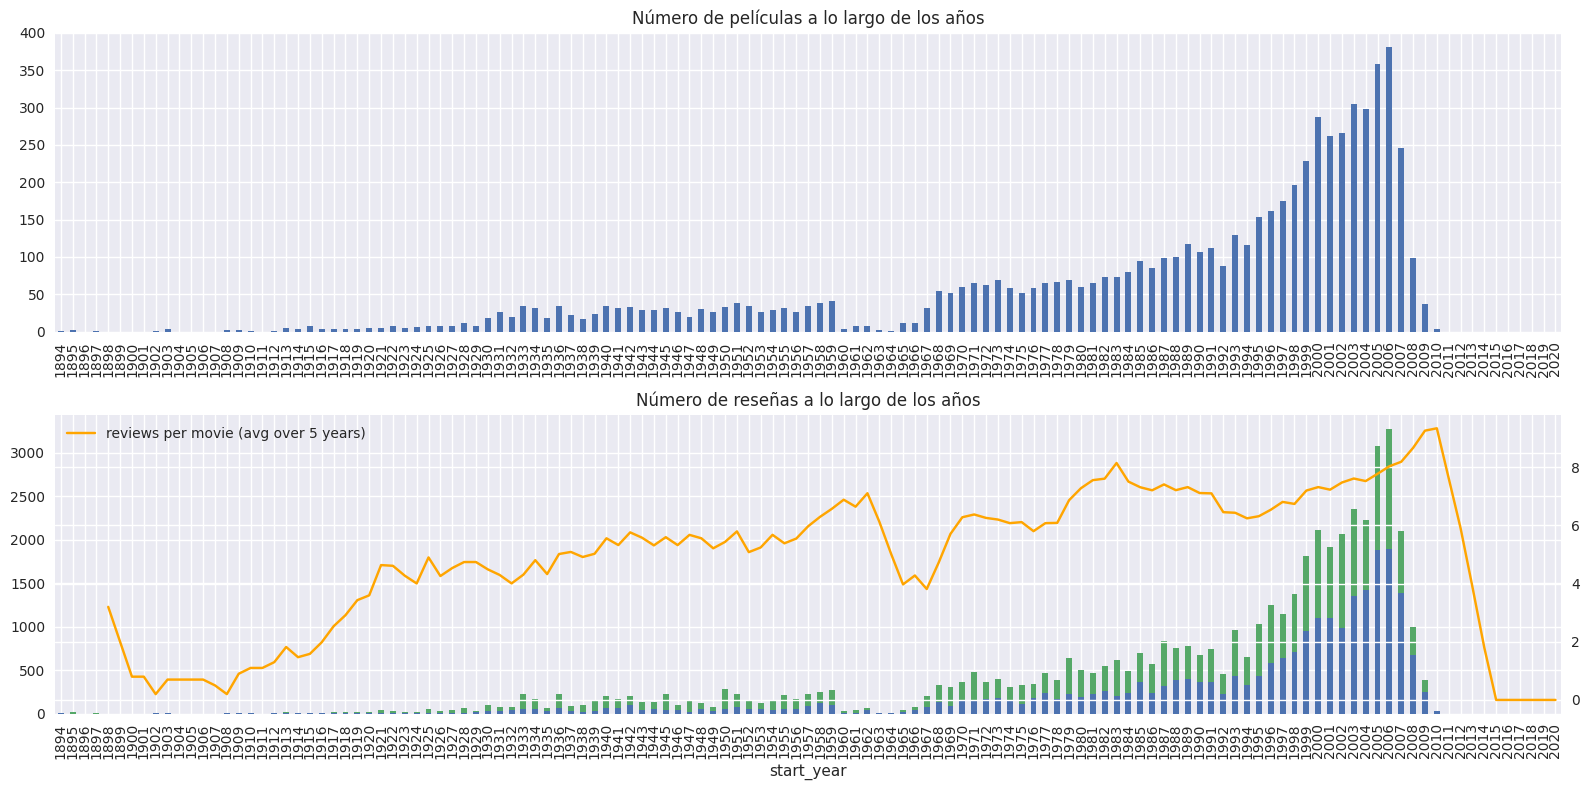

In [35]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

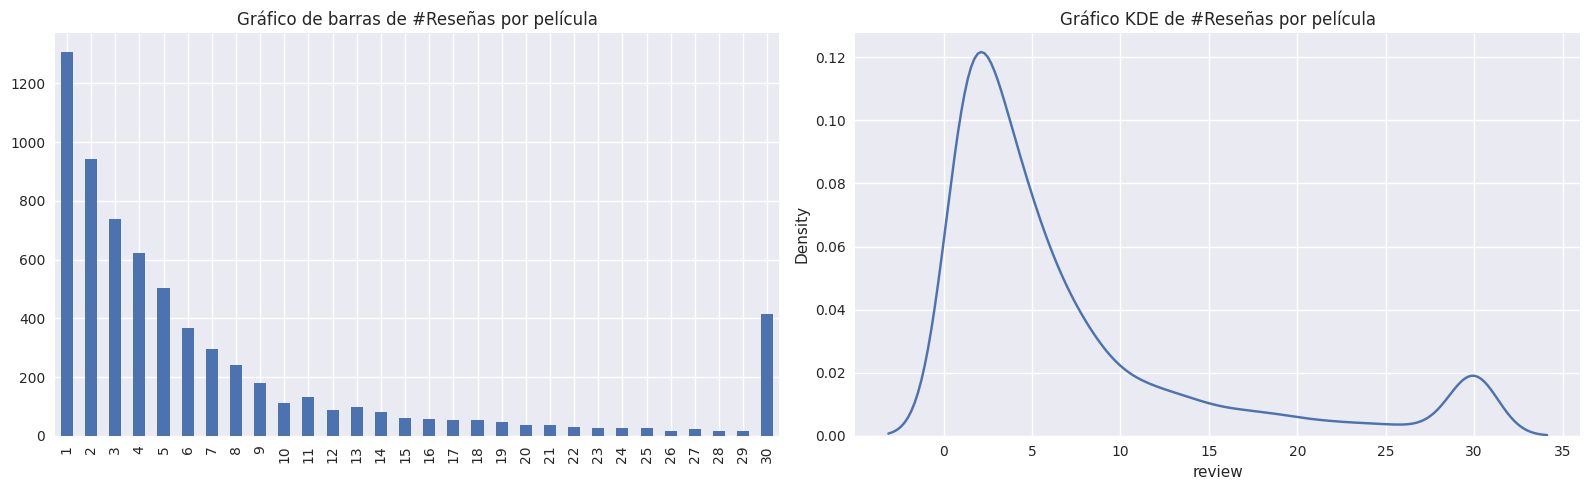

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

In [37]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

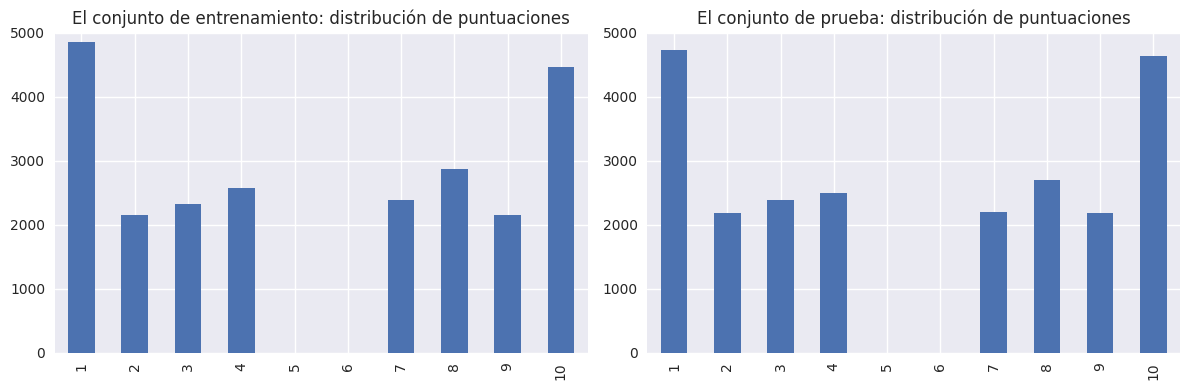

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


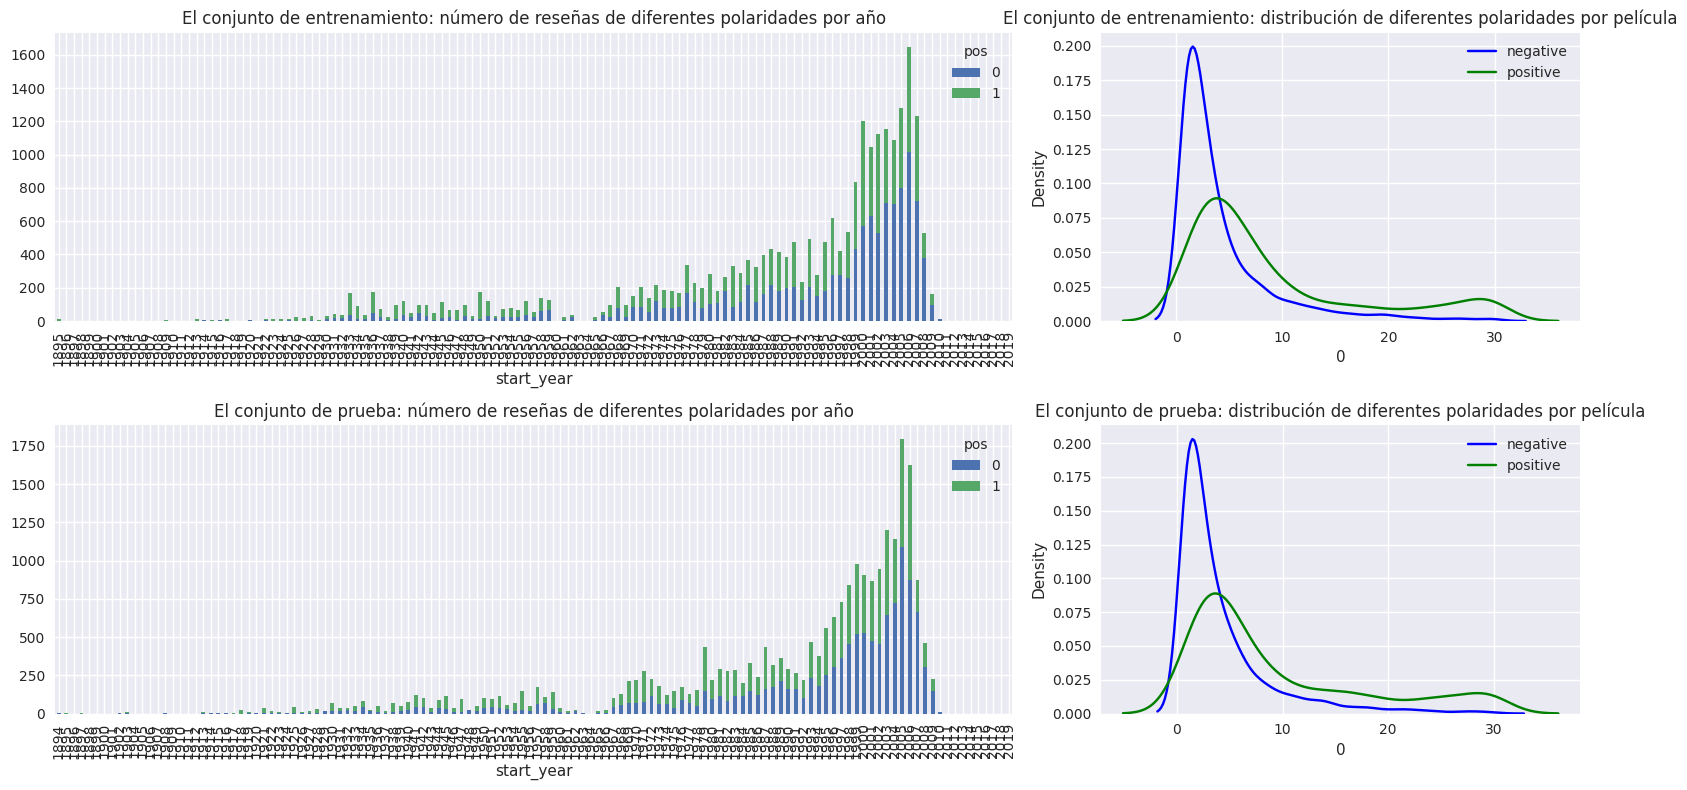

In [39]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [40]:
def evaluate_model(model, train_features, train_target, test_features, test_target):

    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):

        eval_stats[type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1')

        # ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')
        ax.set_title(f'Curva ROC')

        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))

    print(df_eval_stats)

    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [41]:
# Función para normalizar texto
def normalize_text(text):
    text = text.lower()  # minúsculas
    text = re.sub(r'[^a-z\s]', '', text)  # eliminar dígitos, puntuación, etc.
    return text.strip()

In [42]:
df_reviews['review_norm'] = df_reviews['review'].progress_apply(normalize_text)

  0%|          | 0/47331 [00:00<?, ?it/s]

## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [43]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 20)
(23535, 20)


## Trabajar con modelos

### Modelo 0 - Constante

In [45]:
# Se crean las variables train_features y test_features con TF-IDF
tfidf = TfidfVectorizer(max_features=10000)

train_features = tfidf.fit_transform(df_reviews_train['review_norm'])
test_features = tfidf.transform(df_reviews_test['review_norm'])

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


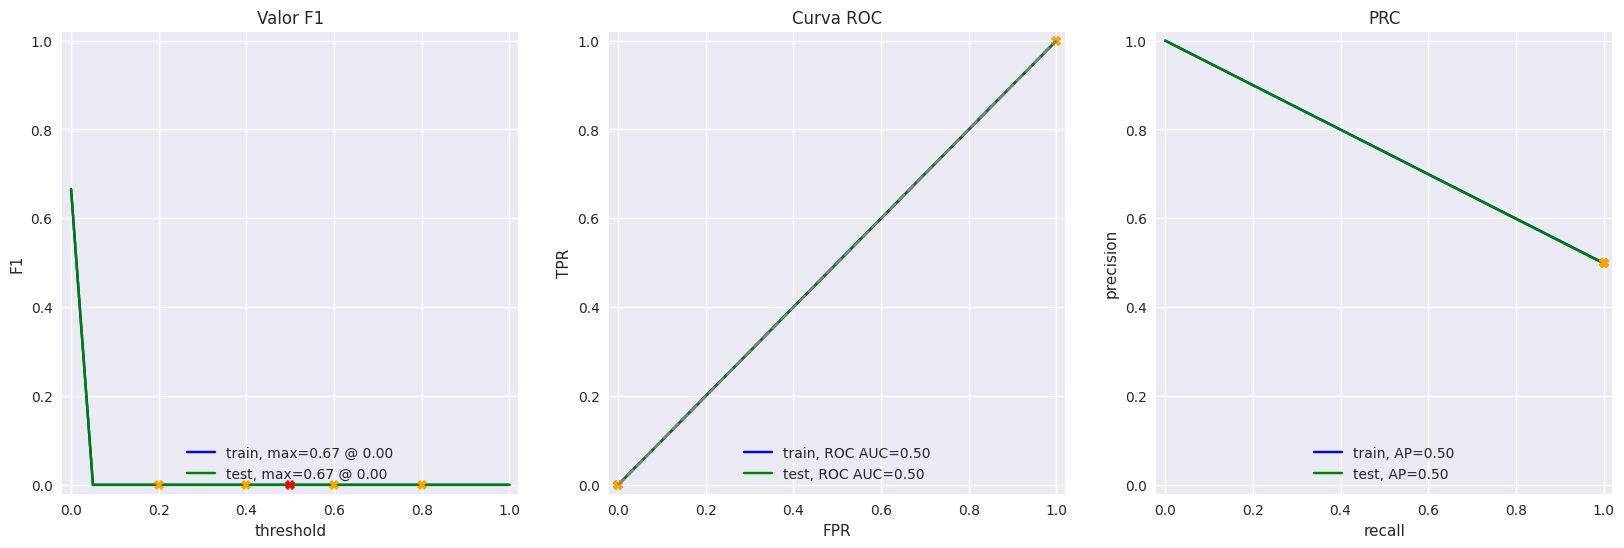

In [46]:
# Clasificador Dummy
model_0 = DummyClassifier(strategy='most_frequent')
model_0.fit(train_features, train_target)

evaluate_model(model_0, train_features, train_target, test_features, test_target)

# Conclusión del Modelo 0:

Este modelo es una línea base para comparar que los demás modelos no tengan métricas similares, ya que predice la clase más frecuente sin analizar el contenido real de las reseñas, por lo que su rendimiento es malo:

- Accuracy: 0.5, tanto en entrenamiento como en prueba, indica que está adivinando sin lógica.

- F1 Score: 0.0, significa que no está identificando correctamente la clase positiva (no acierta ninguna).

- ROC AUC y APS (Average Precision Score): 0.5, es equivalente a un modelo aleatorio. La curva ROC resulta una diagonal perfecta, confirmando que no tiene poder de discriminación.

### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

In [47]:
stop_words = stopwords.words('english')

In [48]:
# Se aplica TF-IDF usando esas stop_words
tfidf_1 = TfidfVectorizer(max_features=10000, stop_words=stop_words)

train_features_1 = tfidf_1.fit_transform(df_reviews_train['review_norm'])
test_features_1 = tfidf_1.transform(df_reviews_test['review_norm'])

In [49]:
# Entrenamiento del modelo
model_1 = LogisticRegression(max_iter=1000)
model_1.fit(train_features_1, train_target)

LogisticRegression(max_iter=1000)

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


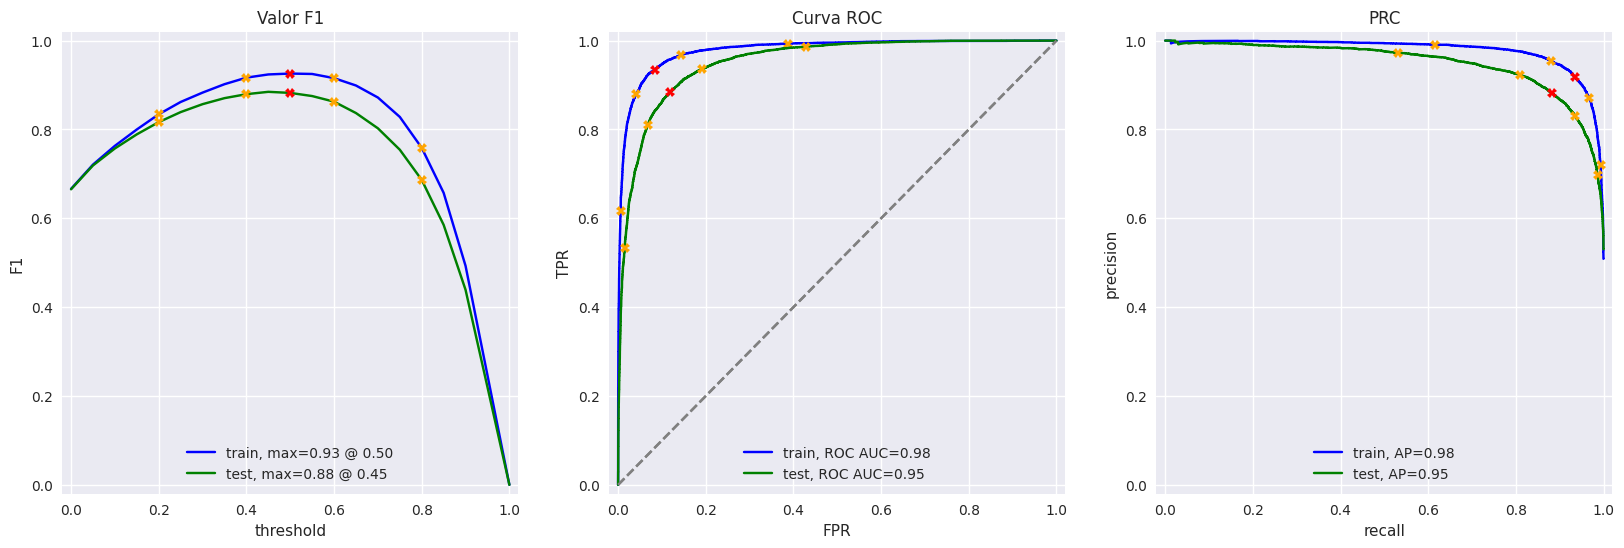

In [50]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

# Conclusión del Modelo 1:

Los resultados del Modelo 1 son excelentes y demuestran que el modelo sí logró aprender patrones reales en las reseñas, predeciendo con alta precisión si una reseña es positiva o negativa, de acuerdo a lo siguiente:

- Accuracy: 0.93 en entrenamiento y 0.88 en prueba → El modelo generaliza bien.

- F1 Score: 0.93 (train), 0.88 (test) → Buen equilibrio entre precisión y recall.

- ROC AUC: 0.98 (train), 0.95 (test) → El modelo distingue muy bien entre clases positivas y negativas.

- APS: 0.98 (train), 0.95 (test) → También tiene excelente rendimiento en tareas desbalanceadas.

- En la curva ROC, la línea está muy cerca del vértice superior izquierdo, lo cual indica un modelo muy preciso.

- La curva de precisión-recall (PRC) también es muy alta, lo cual respalda el alto F1.

- La gráfica de F1 por umbral muestra un punto óptimo muy claro cerca del 0.5, lo que ayuda en caso de querer ajustar el umbral para maximizar F1.

Además, la diferencia entre entrenamiento y prueba es pequeña, lo que sugiere que no hay sobreajuste importante.

### Modelo 3 - spaCy, TF-IDF y LR

In [51]:
tqdm.pandas()  # para barra de progreso

# Cargar modelo de lenguaje en inglés
nlp = spacy.load("en_core_web_sm")

# Limitar a 50 reseñas para prueba rápida
df_small = df_reviews.sample(50, random_state=42).copy()

# Lematización
def lemmatize_spacy(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])

df_small['lemmatized_text'] = df_small['review_norm'].progress_apply(lemmatize_spacy)

# Vectorización
tfidf_3 = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_3.fit_transform(df_small['lemmatized_text'])

# División train/test
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_tfidf, df_small['pos'], test_size=0.2, random_state=42)

# Entrenar modelo
lr_model_3 = LogisticRegression(max_iter=1000)
lr_model_3.fit(X_train_3, y_train_3)

# Evaluar
y_pred_3 = lr_model_3.predict(X_test_3)
print(classification_report(y_test_3, y_pred_3))


100%|██████████| 50/50 [00:01<00:00, 27.38it/s]


              precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       0.67      1.00      0.80         4

    accuracy                           0.80        10
   macro avg       0.83      0.83      0.80        10
weighted avg       0.87      0.80      0.80        10



# Conclusión del Modelo 3:

Con base en los resultados obtenidos, se puede concluir que el modelo muestra un rendimiento aceptable, a pesar de que el tamaño del conjunto de prueba sea reducido (solo 50 ejemplos). La precisión perfecta en la clase 0 y el recall perfecto en la clase 1 sugieren que el modelo ha aprendido patrones útiles, aunque también puede estar sobreajustado a algunos casos particulares.

- Exactitud (accuracy): 80%

- Precisión:

Clase 0: 1.00 (perfecta), aunque esto puede deberse a pocos ejemplos.

Clase 1: 0.67, indicando que algunos falsos positivos ocurrieron.

- Recall (exhaustividad):

Clase 0: 0.67, por lo tanto, no detectó todos los ejemplos reales de la clase 0.

Clase 1: 1.00, detectó todos los ejemplos reales de la clase 1.

- F1-score (media armónica entre precisión y recall):

Ambas clases tienen un F1 de 0.80, lo que indica un buen equilibrio entre precisión y recall.

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

In [53]:
tqdm.pandas()  # para mostrar barra de progreso

# Cargar modelo de lenguaje en inglés de spaCy
nlp = spacy.load("en_core_web_sm")

# Limitar a 50 reseñas para prueba rápida
df_small = df_reviews.sample(50, random_state=42).copy()

# Lematización
def lemmatize_spacy(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])

# Aplicar lematización con progreso
df_small['lemmatized_text'] = df_small['review_norm'].progress_apply(lemmatize_spacy)

# Vectorización TF-IDF
tfidf_4 = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_4.fit_transform(df_small['lemmatized_text'])

# División en entrenamiento y prueba
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(
    X_tfidf, df_small['pos'], test_size=0.2, random_state=42
)

# Modelo LightGBM
lgbm_model = LGBMClassifier(random_state=42)
lgbm_model.fit(X_train_4, y_train_4)

# Evaluación
y_pred_4 = lgbm_model.predict(X_test_4)
print(classification_report(y_test_4, y_pred_4))


100%|██████████| 50/50 [00:01<00:00, 28.38it/s]

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         6
           1       0.57      1.00      0.73         4

    accuracy                           0.70        10
   macro avg       0.79      0.75      0.70        10
weighted avg       0.83      0.70      0.69        10



# Conclusión del Modelo 4:

El modelo detecta bien las reseñas positivas (recall = 1.00) pero confunde muchas negativas como positivas. Asimismo, aunque tuvo una precisión perfecta para las reseñas negativas, su recall es bajo, lo que sugiere que hay un desequilibrio o un sesgo hacia clasificar como positivas.

- Accuracy general: 0.70 (70%)

- F1-score promedio (macro): 0.70

Describiendo los análisis por clase:

- Clase 0 (reseñas negativas):

Precisión (precision): 1.00 → Todas las reseñas clasificadas como negativas realmente lo eran.

Exhaustividad (recall): 0.50 → Solo la mitad de las reseñas negativas reales fueron detectadas.

F1-score: 0.67

- Clase 1 (reseñas positivas):

Precisión: 0.57 → De todas las reseñas que el modelo clasificó como positivas, solo el 57% lo eran realmente.

Recall: 1.00 → Detectó todas las reseñas positivas.

F1-score: 0.73



# Comentario General del Revisor

<div class="alert alert-block alert-success">

<b>Comentario del revisor</b> <a class="tocSkip"></a>

María, has realizado un excelente trabajo hasta este punto. El proyecto está bien encaminado y cumple con los criterios esenciales para ser aprobado. Has implementado correctamente las fases de procesamiento, modelado y evaluación, lo que demuestra una buena comprensión del flujo de trabajo en ciencia de datos.

Respecto a la sección de BERT, es importante aclarar que su ejecución es **opcional** y no es trivial. Dado que este tipo de modelo requiere recursos específicos y ejecución en entornos como **Google Colab**, lo más recomendable es que consultes con tu tutora para recibir una guía adecuada sobre cómo proceder. Ellos pueden orientarte sobre la configuración del entorno y los pasos técnicos necesarios para ejecutar BERT correctamente.

Por ahora, puedes estar tranquila con el avance logrado. Continúa con el cierre del proyecto o consulta cómo documentar este tramo final si decides no ejecutar el modelo BERT.

Buen trabajo.

</div>


<div class="alert alert-block alert-info">
<b>Respuesta del estudiante</b> <a class="tocSkip"></a>
    
**De acuerdo, muchas gracias, revisor Hesús :) por el momento no haré el modelo BERT entonces.
    Me saltaré a la sección de "Mis reseñas" (los modelos 2, 3 y 4) para probar los textos y mostrar que los modelos funcionan.**
    
</div>


###  Modelo 9 - BERT

In [55]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [56]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):

    ids_list = []
    attention_mask_list = []

    # texto al id de relleno de tokens junto con sus máscaras de atención

    # <escribe tu código aquí para crear ids_list y attention_mask_list>

    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)
    if not disable_progress_bar:
        print(f'Uso del dispositivo {device}.')

    # obtener insertados en lotes

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):

        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # <escribe tu código aquí para crear attention_mask_batch

        with torch.no_grad():
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())

    return np.concatenate(embeddings)

In [57]:
# ¡Atención! La ejecución de BERT para miles de textos puede llevar mucho tiempo en la CPU, al menos varias horas
train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

In [ ]:
# si ya obtuviste los insertados, te recomendamos guardarlos para tenerlos listos si
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# y cargar...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

<div class="alert alert-block alert-info">
<b>Respuesta del estudiante</b> <a class="tocSkip"></a>


    
**A partir de aquí, continúo con el proyecto.**
    
</div>


## Mis reseñas

In [58]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

# Normalizar reseñas con la misma función que el dataset principal
my_reviews['review_norm'] = my_reviews['review'].apply(normalize_text)

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didnt expect the reboot to be so good writer...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i reall...


### Modelo 1

In [59]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(tfidf_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')


0.19:  i did not simply like it not my kind of movie
0.17:  well i was bored and felt asleep in the middle of the movie
0.59:  i was really fascinated with the movie
0.12:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.22:  i didnt expect the reboot to be so good writers really cared about the source material
0.51:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.05:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.90:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Modelo 3

In [60]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = lr_model_3.predict_proba(tfidf_3.transform(texts.apply(lambda x: normalize_text(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.44:  i did not simply like it not my kind of movie
0.49:  well i was bored and felt asleep in the middle of the movie
0.52:  i was really fascinated with the movie
0.53:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.52:  i didnt expect the reboot to be so good writers really cared about the source material
0.49:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.48:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.52:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Modelo 4

In [65]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = lgbm_model.predict_proba(tfidf_4.transform(texts.apply(lambda x: normalize_text(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.43:  i did not simply like it not my kind of movie
0.53:  well i was bored and felt asleep in the middle of the movie
0.53:  i was really fascinated with the movie
0.53:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.63:  i didnt expect the reboot to be so good writers really cared about the source material
0.43:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.53:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.63:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


<div class="alert alert-block alert-info">
<b>Respuesta del estudiante</b> <a class="tocSkip"></a>


    
**Esta parte del Modelo 9 se omite, ya que es de BERT.**
    
</div>


### Modelo 9

In [ ]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

# Conclusión sobre los resultados con las reseñas

Al aplicar los modelos entrenados sobre un conjunto de reseñas nuevas, se observó que el Modelo 1 mantiene una buena capacidad de discriminación entre reseñas positivas y negativas, mostrando probabilidades coherentes con el tono del texto (ej. valores muy bajos en críticas negativas y muy altos en reseñas claramente positivas). En contraste, los Modelos 3 y 4 se muestran mucho más conservadores, asignando puntajes cercanos a 0.5 en casi todas las reseñas, lo que refleja una mayor indecisión y menor sensibilidad para diferenciar entre polaridades. En este sentido, el Modelo 1 resulta ser el más confiable para predecir sentimientos en reseñas reales.

# Conclusión Final

*En este proyecto se trabajó con un dataset de más de 47 mil reseñas balanceadas en clases positivas y negativas, lo que permitió entrenar y evaluar diversos modelos de clasificación de texto. Tras aplicar técnicas de preprocesamiento, vectorización y modelado, se encontró que el Modelo 1 logra un rendimiento sobresaliente, con métricas muy altas (Accuracy = 0.88 en prueba, F1 = 0.88, ROC AUC = 0.95), lo que demuestra una excelente capacidad de generalización y discriminación entre clases.

Por otro lado, los Modelos 3 y 4 presentaron rendimientos aceptables en métricas de evaluación, pero muestran limitaciones importantes: el Modelo 3 tiende a sobreajustarse en algunos casos y el Modelo 4, aunque detecta bien reseñas positivas, presenta sesgo al clasificar negativas. Estas tendencias se confirmaron al probar los modelos en un conjunto de reseñas nuevas, donde ambos modelos otorgaron probabilidades cercanas a 0.5 en casi todos los ejemplos, lo que refleja falta de seguridad en sus predicciones.

En contraste, el Modelo 1 mantuvo consistencia y capacidad para distinguir reseñas positivas y negativas en datos reales, lo que refuerza su solidez como mejor alternativa dentro de las opciones evaluadas. 
En conclusión, el proyecto demuestra que, a través de un adecuado preprocesamiento y el uso de representaciones basadas en TF-IDF, es posible entrenar un modelo eficaz para análisis de sentimiento en reseñas de películas, siendo el Modelo 1 la mejor elección final para este caso de estudio.*